In [1]:
%matplotlib inline
import os, sys

import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
#from gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras_ex.gkernel.sklearn import (
    RBFRegressor, RBFClassifier,
    make_model_gkernel1,
    make_model_gkernel2,
    make_model_gkernel3,
    make_model_out,
    make_model
)

In [3]:
# from sklearn.datasets import load_digits
# digits = load_digits()
# X, y = digits.data, digits.target
# X = X / 16
# X.shape, X.min(), X.max()

In [4]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [5]:
X, y = mnist.data, mnist.target
X = X / 255
X.shape, X.min(), X.max()

((70000, 784), 0.0, 1.0)

In [6]:
y.shape

(70000,)

In [7]:
y_cat = to_categorical(y, num_classes=10)
y_cat.shape

(70000, 10)

In [8]:
(
    x_train, x_test,
    y_cat_train, y_cat_test,
    y_train, y_test
) = train_test_split(X, y_cat, y,
                     test_size=0.4,
                     stratify=y, random_state=10002)

(
    x_train.shape, x_test.shape,
    y_cat_train.shape, y_cat_test.shape,
    y_train.shape, y_test.shape
)

((42000, 784), (28000, 784), (42000, 10), (28000, 10), (42000,), (28000,))

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, Lasso
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import joblib

from lightgbm import LGBMClassifier

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def f1_scorer(estimator, X, y):
    pred = estimator.predict(X)
    s = f1_score(y, pred, average='macro')
    return s

## clf1

In [12]:
clf1 = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=10001,
    #make_model_gkernel=make_model_gkernel3,
    #tol=float(np.sqrt(np.finfo(np.float32).eps)/2),
    lr=0.05, gamma='scale',
    epochs=50, batch_size=500, verbose=0,
    session_clear=False
)
# clf1 = LGBMClassifier(min_child_samples=50, reg_alpha=0.1)

In [13]:
%%time
#hst = clf1.fit(x_train, y_cat_train)
hst = clf1.fit(x_train, y_train)

W1007 21:36:01.876602 140255110289216 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 21:36:01.891154 140255110289216 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 21:36:01.899118 140255110289216 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1007 21:36:01.899920 140255110289216 deprecation_wrapper.py:119] From /home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. P

CPU times: user 2min 23s, sys: 5.18 s, total: 2min 28s
Wall time: 1min 23s


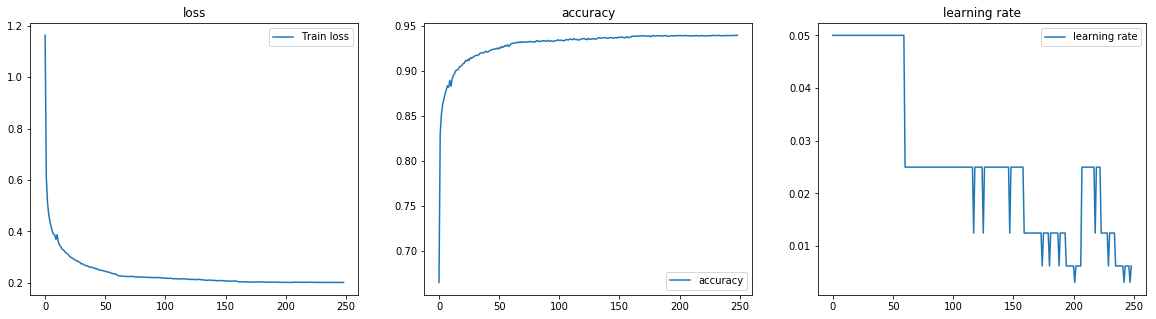

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [15]:
pred = clf1.predict(x_train)
pred.shape

(42000,)

In [16]:
pred

array([2., 9., 9., ..., 8., 4., 1.])

In [17]:
print('F1_SCORE :', f1_score(y_train, pred, average='macro'))
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

F1_SCORE : 0.9380658257048072
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4142
         1.0       0.97      0.98      0.97      4726
         2.0       0.93      0.93      0.93      4194
         3.0       0.93      0.91      0.92      4285
         4.0       0.93      0.94      0.93      4094
         5.0       0.92      0.92      0.92      3788
         6.0       0.96      0.96      0.96      4125
         7.0       0.94      0.94      0.94      4376
         8.0       0.92      0.91      0.92      4095
         9.0       0.91      0.91      0.91      4175

   micro avg       0.94      0.94      0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000

[[4039    0   10    4    9   29   22    8   17    4]
 [   1 4612   21   11    8   11    7   13   36    6]
 [  18   19 3900   43   51   16   23   53   61   10]
 [   7   14   85 3918    5  109    7   38   68   34]

In [18]:
pred_test = clf1.predict(x_test)
pred_test.shape

(28000,)

In [19]:
print('F1_SCORE :', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

F1_SCORE : 0.9352672837701773
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2761
         1.0       0.97      0.98      0.97      3151
         2.0       0.93      0.92      0.92      2796
         3.0       0.92      0.91      0.92      2856
         4.0       0.92      0.94      0.93      2730
         5.0       0.91      0.92      0.91      2525
         6.0       0.96      0.96      0.96      2751
         7.0       0.95      0.94      0.94      2917
         8.0       0.92      0.91      0.91      2730
         9.0       0.91      0.91      0.91      2783

   micro avg       0.94      0.94      0.94     28000
   macro avg       0.94      0.94      0.94     28000
weighted avg       0.94      0.94      0.94     28000

[[2694    0    9    1    0   20   17    2   13    5]
 [   1 3079   10   12    1   11    4    5   18   10]
 [  16   15 2573   30   44    7   20   23   62    6]
 [   2    3   50 2606    1   89    7   29   46   23]

## clf2

In [20]:
clf2 = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=10002,
    #make_model_gkernel=make_model_gkernel3,
    #tol=float(np.sqrt(np.finfo(np.float32).eps)/2),
    lr=0.05, gamma='scale',
    epochs=50, batch_size=500, verbose=0,
    session_clear=False
)
# clf2 = LGBMClassifier(min_child_samples=50, reg_alpha=0.1)

In [21]:
%%time
#hst = clf2.fit(x_train, y_cat_train)
hst = clf2.fit(x_train, y_train)

CPU times: user 2min 23s, sys: 2.42 s, total: 2min 25s
Wall time: 1min 18s


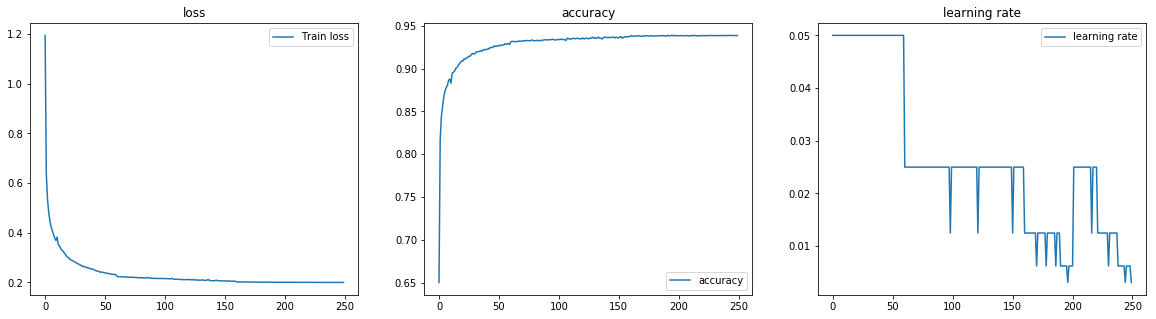

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [23]:
pred = clf2.predict(x_train)
pred.shape

(42000,)

In [24]:
pred

array([2., 9., 9., ..., 8., 4., 1.])

In [25]:
print('F1_SCORE :', f1_score(y_train, pred, average='macro'))
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

F1_SCORE : 0.9378458133060084
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4142
         1.0       0.97      0.98      0.97      4726
         2.0       0.93      0.93      0.93      4194
         3.0       0.92      0.91      0.92      4285
         4.0       0.92      0.94      0.93      4094
         5.0       0.92      0.92      0.92      3788
         6.0       0.96      0.97      0.96      4125
         7.0       0.94      0.94      0.94      4376
         8.0       0.93      0.91      0.92      4095
         9.0       0.92      0.90      0.91      4175

   micro avg       0.94      0.94      0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000

[[4042    0   13    6    8   18   21   11   21    2]
 [   0 4618   24   11    9   10    4   14   31    5]
 [  20   20 3887   51   54   20   35   48   47   12]
 [   5   17   81 3911    2  127    9   36   69   28]

In [26]:
pred_test = clf2.predict(x_test)
pred_test.shape

(28000,)

In [27]:
print('F1_SCORE :', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

F1_SCORE : 0.9351327003928022
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2761
         1.0       0.98      0.98      0.98      3151
         2.0       0.92      0.93      0.92      2796
         3.0       0.92      0.91      0.92      2856
         4.0       0.92      0.93      0.93      2730
         5.0       0.92      0.92      0.92      2525
         6.0       0.95      0.96      0.96      2751
         7.0       0.95      0.93      0.94      2917
         8.0       0.91      0.91      0.91      2730
         9.0       0.91      0.90      0.91      2783

   micro avg       0.94      0.94      0.94     28000
   macro avg       0.94      0.94      0.94     28000
weighted avg       0.94      0.94      0.94     28000

[[2698    0   15    1    0   12   15    4   14    2]
 [   1 3086   13   11    1    6    2    5   19    7]
 [   7   10 2590   31   44    7   24   19   61    3]
 [   7    5   43 2604    0   92    8   26   49   22]

## clf3

In [28]:
clf3 = RBFClassifier(
    num_lm=150,
    lm_select_from_x=True,
    random_state=10003,
    #make_model_gkernel=make_model_gkernel3,
    #tol=float(np.sqrt(np.finfo(np.float32).eps)/2),
    lr=0.05, gamma='scale',
    epochs=50, batch_size=500, verbose=0,
    session_clear=False
)
# clf3 = LGBMClassifier(min_child_samples=50, reg_alpha=0.1)

In [29]:
%%time
#hst = clf3.fit(x_train, y_cat_train)
hst = clf3.fit(x_train, y_train)

CPU times: user 2min 18s, sys: 2.44 s, total: 2min 20s
Wall time: 1min 21s


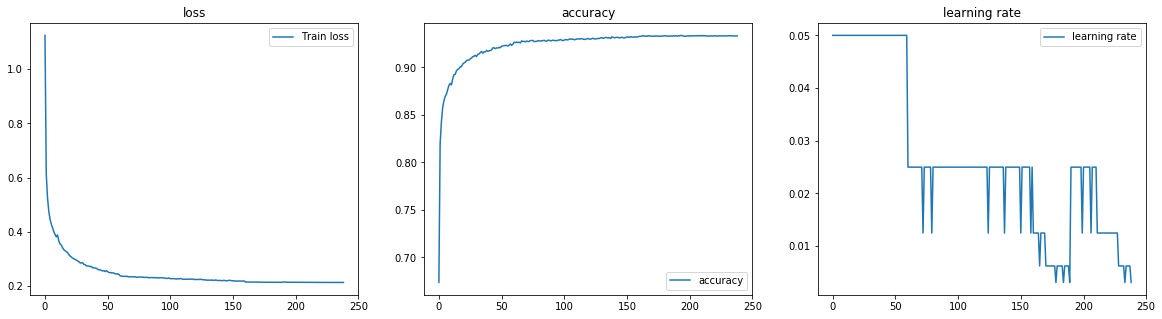

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].set_title('loss')
ax[0].plot(list(range(len(hst["loss"]))), hst["loss"], label="Train loss")
ax[1].set_title('accuracy')
ax[1].plot(list(range(len(hst["loss"]))), hst["acc"], label="accuracy")
ax[2].set_title('learning rate')
ax[2].plot(list(range(len(hst["loss"]))), hst["lr"], label="learning rate")
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [31]:
pred = clf3.predict(x_train)
pred.shape

(42000,)

In [32]:
pred

array([2., 9., 9., ..., 8., 4., 1.])

In [33]:
print('F1_SCORE :', f1_score(y_train, pred, average='macro'))
print(classification_report(y_train, pred))
print(confusion_matrix(y_train, pred))

F1_SCORE : 0.9325468535613665
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4142
         1.0       0.97      0.97      0.97      4726
         2.0       0.92      0.92      0.92      4194
         3.0       0.92      0.92      0.92      4285
         4.0       0.93      0.94      0.93      4094
         5.0       0.90      0.91      0.91      3788
         6.0       0.95      0.96      0.95      4125
         7.0       0.94      0.93      0.93      4376
         8.0       0.91      0.90      0.91      4095
         9.0       0.91      0.90      0.90      4175

   micro avg       0.93      0.93      0.93     42000
   macro avg       0.93      0.93      0.93     42000
weighted avg       0.93      0.93      0.93     42000

[[4033    0    9    7    5   27   26    6   17   12]
 [   0 4606   24   12    8   21    4   15   31    5]
 [  20   19 3860   47   49   15   44   55   72   13]
 [   8   21   78 3926    5  110    8   31   72   26]

In [34]:
pred_test = clf3.predict(x_test)
pred_test.shape

(28000,)

In [35]:
print('F1_SCORE :', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test))
print(confusion_matrix(y_test, pred_test))

F1_SCORE : 0.9318543544269613
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      2761
         1.0       0.97      0.98      0.97      3151
         2.0       0.92      0.92      0.92      2796
         3.0       0.93      0.91      0.92      2856
         4.0       0.93      0.93      0.93      2730
         5.0       0.92      0.91      0.91      2525
         6.0       0.95      0.96      0.95      2751
         7.0       0.93      0.93      0.93      2917
         8.0       0.90      0.90      0.90      2730
         9.0       0.91      0.90      0.90      2783

   micro avg       0.93      0.93      0.93     28000
   macro avg       0.93      0.93      0.93     28000
weighted avg       0.93      0.93      0.93     28000

[[2694    0    7    3    1   17   15    3   12    9]
 [   1 3077   12   12    3   13    4    5   17    7]
 [   8   12 2572   23   36    9   37   28   66    5]
 [   7    5   50 2601    0   74    8   28   59   24]

In [36]:
clfs = [clf1, clf2, clf3]

In [37]:
pred_proba = [clf.predict_proba(x_train) for clf in clfs]

In [38]:
np.stack(pred_proba).mean(axis=0).shape

(42000, 10)

In [39]:
print('F1_SCORE :', f1_score(y_train, np.argmax(np.stack(pred_proba).mean(axis=0), axis=1), average='macro'))
print(classification_report(y_train, np.argmax(np.stack(pred_proba).mean(axis=0), axis=1)))
print(confusion_matrix(y_train, np.argmax(np.stack(pred_proba).mean(axis=0), axis=1)))

F1_SCORE : 0.9418468613253521
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4142
         1.0       0.97      0.98      0.97      4726
         2.0       0.93      0.93      0.93      4194
         3.0       0.93      0.92      0.93      4285
         4.0       0.93      0.95      0.94      4094
         5.0       0.92      0.93      0.93      3788
         6.0       0.96      0.97      0.96      4125
         7.0       0.95      0.94      0.94      4376
         8.0       0.93      0.92      0.92      4095
         9.0       0.92      0.91      0.92      4175

   micro avg       0.94      0.94      0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000

[[4056    0   12    6    6   15   20    8   16    3]
 [   0 4619   20   11    8   15    6   14   28    5]
 [  19   18 3905   41   48   16   32   50   54   11]
 [   7   18   75 3938    5  104    9   32   69   28]

In [40]:
pred_proba_test = [clf.predict_proba(x_test) for clf in clfs]

In [41]:
np.stack(pred_proba_test).mean(axis=0).shape

(28000, 10)

In [42]:
print('F1_SCORE :', f1_score(y_test, np.argmax(np.stack(pred_proba_test).mean(axis=0), axis=1), average='macro'))
print(classification_report(y_test, np.argmax(np.stack(pred_proba_test).mean(axis=0), axis=1)))
print(confusion_matrix(y_test, np.argmax(np.stack(pred_proba_test).mean(axis=0), axis=1)))

F1_SCORE : 0.9406496614458144
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2761
         1.0       0.97      0.98      0.98      3151
         2.0       0.93      0.93      0.93      2796
         3.0       0.93      0.92      0.93      2856
         4.0       0.93      0.94      0.93      2730
         5.0       0.92      0.93      0.93      2525
         6.0       0.96      0.97      0.96      2751
         7.0       0.95      0.94      0.94      2917
         8.0       0.92      0.92      0.92      2730
         9.0       0.92      0.91      0.92      2783

   micro avg       0.94      0.94      0.94     28000
   macro avg       0.94      0.94      0.94     28000
weighted avg       0.94      0.94      0.94     28000

[[2706    1    7    1    0   15   14    3   11    3]
 [   1 3083   11   12    2   10    2    5   17    8]
 [   9   11 2598   26   41    5   24   22   57    3]
 [   4    4   41 2627    1   80    7   27   44   21]